# Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series

Andreas Natanael Bunyamin \\
andreasbunyamin@gmail.com


Pada proyek ini saya akan mengimplementasikan Machine Learning untuk kasus time series dalam memprediksi ----. Dataset yang saya gunakan adalah "[Bike Sharing Dataset](https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset)" yang diambil dari UC Irvine Machine Learning Repository.

In [2]:
#Import Library
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
#Download Dataset
!wget --no-check-certificate \
  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip \
  -O /content/Bike-Sharing-Dataset.zip

--2024-01-17 17:38:17--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/content/Bike-Sharing-Dataset.zip’

/content/Bike-Shari     [   <=>              ] 273.43K   530KB/s    in 0.5s    

2024-01-17 17:38:18 (530 KB/s) - ‘/content/Bike-Sharing-Dataset.zip’ saved [279992]



In [3]:
!unzip '/content/Bike-Sharing-Dataset.zip'

Archive:  /content/Bike-Sharing-Dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


In [5]:
df = pd.read_csv('/content/hour.csv')
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [6]:
#Mengecek kolom kosong
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [7]:
df = df.drop(['instant', 'atemp', 'weekday', 'casual', 'registered'], axis=1)
df

,dteday,season,yr,mnth,hr,holiday,workingday,weathersit,temp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,0,0,1,0.24,0.81,0.0000,16
1,2011-01-01,1,0,1,1,0,0,1,0.22,0.80,0.0000,40
2,2011-01-01,1,0,1,2,0,0,1,0.22,0.80,0.0000,32
3,2011-01-01,1,0,1,3,0,0,1,0.24,0.75,0.0000,13
4,2011-01-01,1,0,1,4,0,0,1,0.24,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31,1,1,12,19,0,1,2,0.26,0.60,0.1642,119
17375,2012-12-31,1,1,12,20,0,1,2,0.26,0.60,0.1642,89
17376,2012-12-31,1,1,12,21,0,1,1,0.26,0.60,0.1642,90
17377,2012-12-31,1,1,12,22,0,1,1,0.26,0.56,0.1343,61


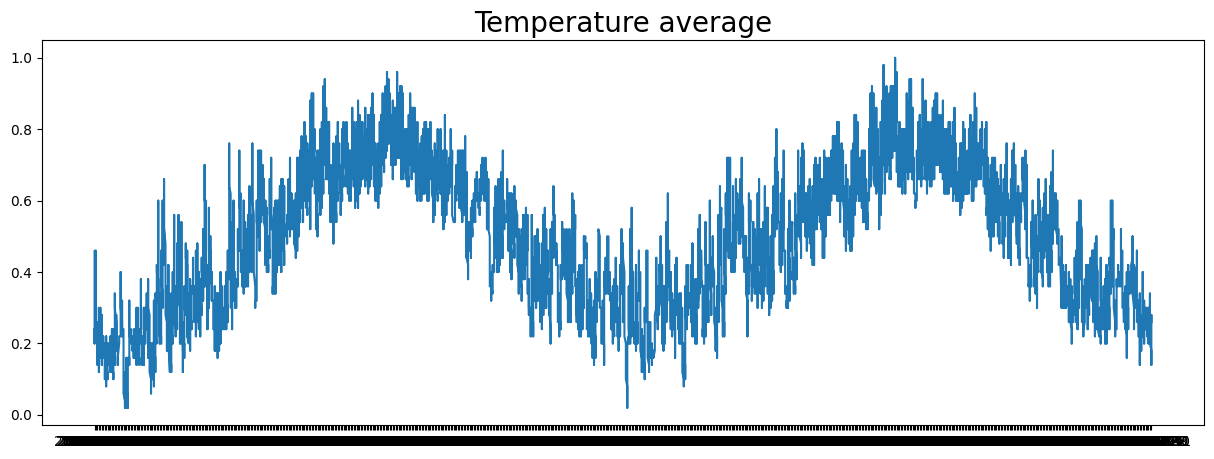

In [8]:
dates = df['dteday'].values
temp  = df['temp'].values

plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average',
          fontsize=20);

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
x_train, x_valid, y_train, y_valid = train_test_split(temp, dates, train_size=0.8, test_size = 0.2, shuffle = False )

In [11]:
train_set = windowed_dataset(x_train, window_size=64, batch_size=200, shuffle_buffer=1000)
val_set = windowed_dataset(x_valid, window_size=64, batch_size=200, shuffle_buffer=1000)

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[64, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

In [17]:
Mae = (df['temp'].max() - df['temp'].min()) * 10/100
print(Mae)

0.098


In [18]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.098):
      print("\nNilai MAE dibawah 10% dari jumlah data!")
      self.model.stop_training = True
callbacks = myCallback()

In [19]:
# Fitting the LSTM to the Training set
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=100,
    callbacks=[callbacks]
)

Epoch 1/100
70/70 [==============================] - 63s 790ms/step - loss: 0.1656 - mae: 0.5328 - val_loss: 0.1218 - val_mae: 0.4603
Epoch 2/100
70/70 [==============================] - 51s 725ms/step - loss: 0.1251 - mae: 0.4562 - val_loss: 0.0982 - val_mae: 0.4096
Epoch 3/100
70/70 [==============================] - 49s 693ms/step - loss: 0.1050 - mae: 0.4129 - val_loss: 0.0831 - val_mae: 0.3726
Epoch 4/100
70/70 [==============================] - 49s 698ms/step - loss: 0.0905 - mae: 0.3778 - val_loss: 0.0717 - val_mae: 0.3409
Epoch 5/100
70/70 [==============================] - 56s 794ms/step - loss: 0.0789 - mae: 0.3473 - val_loss: 0.0622 - val_mae: 0.3119
Epoch 6/100
70/70 [==============================] - 49s 697ms/step - loss: 0.0692 - mae: 0.3202 - val_loss: 0.0541 - val_mae: 0.2850
Epoch 7/100
70/70 [==============================] - 49s 701ms/step - loss: 0.0611 - mae: 0.2964 - val_loss: 0.0472 - val_mae: 0.2605
Epoch 8/100
70/70 [==============================] - 51s 722ms

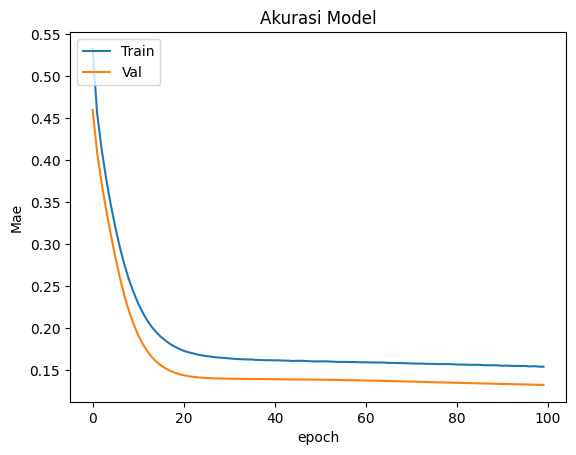

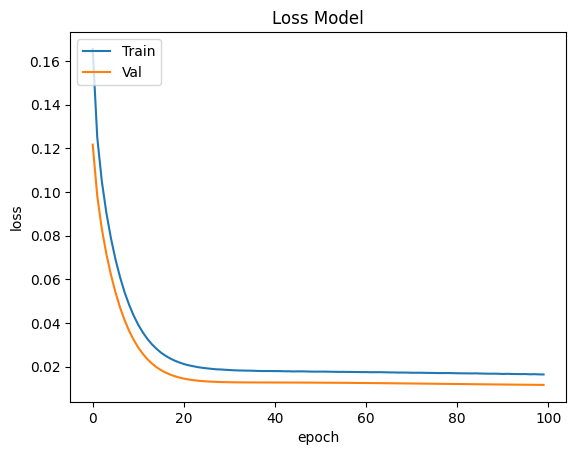

In [21]:
# Plot Accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()